# Image Embeddings Projection

In this notebook, we shall take a group of images, perform an embedding analysis using the [Distant Viewing Toolkit](https://github.com/distant-viewing/dvt), and then project this data into a 2 dimensional space. This is then exported as an annotated IIIF Manifest that can be opened in Millefeuille, rendering an interface very similar to [PixPlot](https://dhlab.yale.edu/projects/pixplot/).

## 1. Setup

First, we need to install and import the various packages that we shall be using.

In [1]:
!pip install -q git+https://github.com/jdchart/millefeuille-api.git
!pip install -q git+https://github.com/distant-viewing/dvt.git
!mkdir -p /root/.cache/torch/hub/checkpoints/

import mfapi
import dvt
import requests
import json
import random
import os
import shutil
import numpy as np
from io import BytesIO
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 778.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

## 2. Get Media

Next we need to find the media that we wish to use. Here, we get some zip files of images and unpack them into their own folders.

In [8]:
if os.path.isdir("frame_averages"):
  shutil.rmtree("frame_averages")
if os.path.isdir("keyframes"):
  shutil.rmtree("keyframes")

os.makedirs("frame_averages")
os.makedirs("keyframes")

if os.path.isfile("frame_averages.zip") == False:
  !wget -q https://files.tetras-libre.fr/media/plozevet/fonds_gessain/frame_averages.zip
if os.path.isfile("keyframes.zip") == False:
  !wget -q https://files.tetras-libre.fr/media/plozevet/fonds_gessain/keyframes.zip

!unzip -q -d "frame_averages" frame_averages.zip
!unzip -q -d "keyframes" keyframes.zip

## 3. Create embeddings

Now we can use the distant viewing toolkit to perform an embedding analysis on these images.

In [12]:
TO_TREAT = [
    "frame_averages",
    "keyframes"
]

embedder = dvt.AnnoEmbed()
file_map = {}

for folder in TO_TREAT:
  file_map[folder] = {}
  for i, file in enumerate(os.listdir(folder)):
    print(f"Treating file {i + 1}/{len(os.listdir(folder))} ({file})...")

    loaded_img = dvt.load_image(os.path.join(folder, file))
    embedding = embedder.run(loaded_img)["embedding"]
    if i == 0:
      embedding_list = embedding
    else:
      embedding_list = np.vstack((embedding_list, embedding))

    file_map[folder][i] = file

  np.save(folder + "_embeddings.npy", embedding_list)
  files.download(folder + "_embeddings.npy")

with open("file_map.json", 'w', encoding='utf-8') as f:
  json.dump(file_map, f, ensure_ascii = False, indent = 2)
files.download("file_map.json")

Treating file 1/2422 (243423bb-e6da-4ddc-bf5f-0708c90dab9b#shot=304&time=1788.76,1793.64.jpg)...
Treating file 2/2422 (243423bb-e6da-4ddc-bf5f-0708c90dab9b#shot=111&time=687.68,705.4.jpg)...
Treating file 3/2422 (243423bb-e6da-4ddc-bf5f-0708c90dab9b#shot=324&time=1918.72,1921.56.jpg)...
Treating file 4/2422 (0812d9f7-eb1d-45ae-92f8-5fbe03c1f7fe#shot=511&time=2489.0,2491.16.jpg)...
Treating file 5/2422 (84652d38-4e64-406c-a66a-71248d3bf272#shot=105&time=658.0,660.64.jpg)...
Treating file 6/2422 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=128&time=624.44,628.24.jpg)...
Treating file 7/2422 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=238&time=1083.36,1086.28.jpg)...
Treating file 8/2422 (ebd8f4d7-e88f-4977-be64-d62503eda739#shot=201&time=1012.04,1015.56.jpg)...
Treating file 9/2422 (243423bb-e6da-4ddc-bf5f-0708c90dab9b#shot=213&time=1257.92,1262.4.jpg)...
Treating file 10/2422 (ebd8f4d7-e88f-4977-be64-d62503eda739#shot=217&time=1062.44,1065.32.jpg)...
Treating file 11/2422 (ebd8f4d7-e88f-49

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Treating file 2247/7246 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=94&time=470.32,483.24_cluster_2.jpg)...
Treating file 2248/7246 (ebd8f4d7-e88f-4977-be64-d62503eda739#shot=86&time=536.08,541.56_cluster_1.jpg)...
Treating file 2249/7246 (0812d9f7-eb1d-45ae-92f8-5fbe03c1f7fe#shot=475&time=2382.64,2384.88_cluster_2.jpg)...
Treating file 2250/7246 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=593&time=2511.04,2514.72_cluster_2.jpg)...
Treating file 2251/7246 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=538&time=2295.96,2298.68_cluster_2.jpg)...
Treating file 2252/7246 (0812d9f7-eb1d-45ae-92f8-5fbe03c1f7fe#shot=69&time=512.12,520.32_cluster_0.jpg)...
Treating file 2253/7246 (82923da2-73bd-4339-b7c9-451d1a295d7e#shot=559&time=2398.04,2401.0_cluster_0.jpg)...
Treating file 2254/7246 (243423bb-e6da-4ddc-bf5f-0708c90dab9b#shot=144&time=885.44,892.16_cluster_2.jpg)...
Treating file 2255/7246 (0812d9f7-eb1d-45ae-92f8-5fbe0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4. Dimensionality Reduction

Now that we have our embedding data, we can use dimensionality reduction to crunch all of these dimensions down into 2 so that they can be projected into a 2-dimensional space. To do this, we'll use an algorithm called [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

In [13]:
for folder in TO_TREAT:
  embedding_data = np.load(folder + "_embeddings.npy")

  standardized = StandardScaler().fit_transform(embedding_data)
  reduced = TSNE(n_components = 2, perplexity=10).fit_transform(standardized)
  normalized = MinMaxScaler((0, 1)).fit_transform(reduced)

  np.save(folder + "_embeddings_normalized.npy", normalized)
  files.download(folder + "_embeddings_normalized.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If we like, we can visualize the data in a scatter plot:

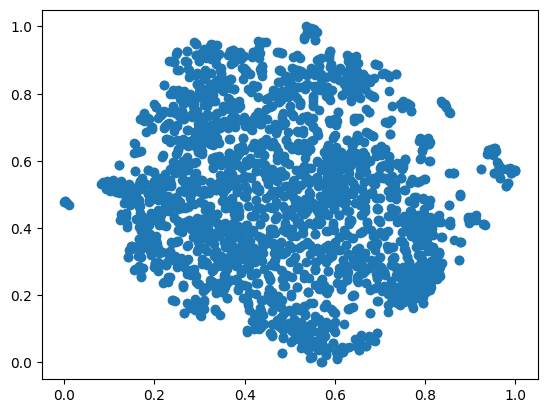

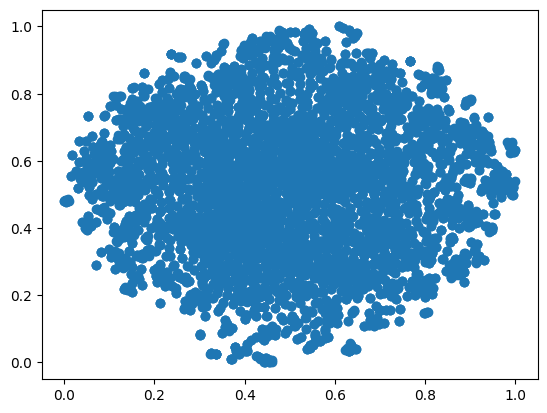

In [14]:
for folder in TO_TREAT:
  normalized = np.load(folder + "_embeddings_normalized.npy")

  transposed = np.transpose(normalized)
  plt.scatter(transposed[0], transposed[1])
  plt.show()

## 6. Visualization

Now we have all the data we need to create a visualization. We shall create a 2-dimensional image that places each of the images at their coordinates.

We shall be making two things:

*   The png image file
*   A list of rendered coordinates so that we can annotate the image later.

Let's create the image:

In [ ]:
WIDTH = 10000
HEIGHT = 10000
PADDING = 1000
IMAGE_ZOOM = 0.25

def scale(val, old_min, old_max, new_min, new_max):
    return new_min + (((val - old_min) * (new_max - new_min)) / (old_max - old_min))

def add_image(full_image, coordinates_list, image_path, coordinates, idx):
  print(f"Adding image {image_path} ({idx + 1}/{len(normalized)})...")

  this_img = Image.open(image_path)
  original_width, original_height = this_img.size

  w = int(original_width * IMAGE_ZOOM)
  h = int(original_height * IMAGE_ZOOM)
  x = int(scale(int(int(float(coordinates[0]) * WIDTH) - (w * 0.5)), 0, WIDTH, PADDING, WIDTH - (PADDING * 2)))
  y = int(scale(int(int(float(coordinates[1]) * HEIGHT) - (h * 0.5)), 0, HEIGHT, PADDING, HEIGHT - (PADDING * 2)))

  this_img = this_img.resize((w, h))
  full_image.paste(this_img, (x, y))

  coordinates_list.append({"file_name" : image_path, "x" : x, "y" : y, "w" : w, "h" : h})

for folder in TO_TREAT:
  normalized = np.load(folder + "_embeddings_normalized.npy")

  full_image = Image.new('RGBA', (WIDTH, HEIGHT))
  coordinates = {"images" : []}

  for i, item in enumerate(normalized):
    add_image(full_image, coordinates["images"], os.path.join(folder, file_map[folder][i]), item, i)

  full_image.save(folder + "_visualisation.png")
  files.download(folder + "_visualisation.png")

  with open(folder + "_coordinate_data.json", 'w', encoding='utf-8') as f:
    json.dump(coordinates, f, ensure_ascii = False, indent = 2)
  files.download(folder + "_coordinate_data.json")

## 7. Export to Millefeuille

Finally, we can take this visualisation and the coordinate data and create an annotated IIIF Manifest from them that can be opened in Millefeuille and interacted with.

First, you need to make the image that was created available online - follow the Adding Media tutorial to do this. Once this is done, set the link to the image here, then create the basic Manifest around it:

In [30]:
def read_json(path):
  with open(path, 'r') as f:
    return json.load(f)

def read_json_online(url):
  response = requests.get(url)
  if response.status_code == 200:
      return json.loads(response.text)

for folder in TO_TREAT:
  cache = {}

  folder_format = folder.replace("_", " ")

  coordinates = read_json(folder + "_coordinate_data.json")

  image_url = f"https://files.tetras-libre.fr/media/plozevet/analyses/{folder}_visualisation.png"

  manifest = mfapi.Manifest(manifest_path = "manifests/plozevet/analyses")
  manifest.label = {"en" : [f"Image Embedding T-SNE Projection ({folder_format})"]}
  manifest.add_canvas_from_media(image_url)

  annotation_page = manifest.add_annotation_page()

  for image in coordinates["images"]:
    original_manifest_id = os.path.basename(image["file_name"]).split("#")[0]
    shot_index = int(image["file_name"].split("#shot=")[1].split("&time=")[0])
    original_manifest_path = f"https://files.tetras-libre.fr/manifests/plozevet/sources/{original_manifest_id}.json"

    if original_manifest_path in list(cache.keys()):
      original_manifest_name = cache[original_manifest_path]
    else:
      original_manifest_data = read_json_online(original_manifest_path)
      original_manifest_name = original_manifest_data["label"]["en"]
      cache[original_manifest_path] = original_manifest_name

    annotation_page.add_annotation(
        link_to_manifest = original_manifest_path,
        x = image["x"],
        y = image["y"],
        w = image["w"],
        h = image["h"],
        label = f"{original_manifest_name} (shot {shot_index})"
    )

  files.download(manifest.to_json())

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clean up any temporary files.

In [28]:
mfapi.clean_up()